In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [2]:
import cirq
import cirq_superstaq as css
import ldpc
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pymatching
import sinter
import stim
import stimcirq
from ldpc.sinter_decoders import SinterBeliefFindDecoder, SinterBpOsdDecoder

import qldpc

In [98]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01)
surface_code_circuit

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19
    X_ERROR(0.01) 1 3 5 8 10 12 15 17 19
    R 2 9 11 13 14 16 18 25
    X_ERROR(0.01) 2 9 11 13 14 16 18 25
    TICK
    DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
    H 2 11 16 25
    DEPOLARIZE1(0.01) 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 

In [119]:
stimcirq.cirq_circuit_to_stim_circuit(stimcirq.stim_circuit_to_cirq_circuit(surface_code_circuit)).detector_error_model(decompose_errors=True)

ValueError: stimcirq.DetAnnotation(parity_keys=['4'], relative_keys=[], coordinate_metadata=(0.0, 4.0, 0.0)) was processed before measurements it referenced (['4']). Make sure the referenced measurements keys are actually in the circuit, and come in an earlier moment (or earlier in the same moment's operation order).

In [4]:
# [X,Z] gates don't contribute to [X, Z] basis SPAM

In [118]:
circuit

┌──┐   ┌──────────────┐                                                           ┌──┐   ┌──────────────┐                                                                                                                              ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐                 ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [                       ┌──┐   ┌──────────────┐                                                           ┌──┐   ┌──────────────┐                                                                                                                              ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐                 ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐                                                                                                                           ]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [ 0: ────────────────────@──────#2──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X──────#2─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [                        │      │                                                                                                                                                                                                                               │      │                                                                                                                                                                                                                                     ]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [ 1: ────────────────────┼──────┼─────────────────@───#2────────@───#2──────────────────────────────────────────────────────────────────────────────────────────────────

In [103]:
d = 3
noise = 0.01
code = qldpc.codes.SurfaceCode(d, rotated=True)
circuit = gen_syndrome_surface_circuit(code, sector = "Z", repetitions=1).with_noise(NoiseModel(noise))
stimcirq.cirq_circuit_to_stim_circuit(circuit)

stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 13 14 15 16 9 10 11 12
    TICK
    X_ERROR(0.01) 0 1 2 3 4 5 6 7 8 13 14 15 16 9 10 11 12
    TICK
    H 13 14 15 16
    TICK
    DEPOLARIZE1(0.01) 13 14 15 16
    TICK
    CZ 13 0 15 3
    TICK
    DEPOLARIZE2(0.01) 13 0 15 3
    TICK
    CZ 13 1
    TICK
    DEPOLARIZE2(0.01) 13 1
    TICK
    CZ 14 1
    TICK
    DEPOLARIZE2(0.01) 14 1
    TICK
    CZ 14 2
    TICK
    DEPOLARIZE2(0.01) 14 2
    TICK
    CZ 14 4
    TICK
    DEPOLARIZE2(0.01) 14 4
    TICK
    CZ 14 5 15 4
    TICK
    DEPOLARIZE2(0.01) 14 5 15 4
    TICK
    CZ 15 6
    TICK
    DEPOLARIZE2(0.01) 15 6
    TICK
    CZ 15 7
    TICK
    DEPOLARIZE2(0.01) 15 7
    TICK
    CZ 16 7
    TICK
    DEPOLARIZE2(0.01) 16 7
    TICK
    CZ 16 8
    TICK
    DEPOLARIZE2(0.01) 16 8
    TICK
    H 13 14 15 16
    TICK
    DEPOLARIZE1(0.01) 13 14 15 16
    TICK
    X_ERROR(0.01) 13 14 15 16
    TICK
    MR 13 14 15 16
    TICK
    X_ERROR(0.01) 13 14 15 16
    TICK
    H 9 10 11 12
    TI

In [123]:
detector_error_model = circuit.detector_error_model(decompose_errors=True)

In [102]:
# Remove hadarmards, prep + meas ancilla in X basis
def gen_syndrome_surface_circuit(surface_code, sector = "X", repetitions=1):
    
    circuit = cirq.Circuit()
    stab_circuit = cirq.Circuit()

    if sector == "X":
        logicals = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
        parity_matrix = surface_code.matrix_x
        offset = len(surface_code.matrix_z)
        
    else:
        logicals = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)
        parity_matrix = surface_code.matrix_z
        offset = 0

    ancillas_x = [cirq.NamedQubit(f"ax{anc_idx}") for anc_idx in range(len(surface_code.matrix_x))]
    ancillas_z = [cirq.NamedQubit(f"az{anc_idx}") for anc_idx in range(len(surface_code.matrix_z))]

    # circuit for a single round of syndrome extraction

    stab_circuit = cirq.Circuit()

    for ancillas, matrix, gate in [(ancillas_z, surface_code.matrix_z, cirq.CZ), (ancillas_x, surface_code.matrix_x, cirq.CX)]:
        stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas))
        for anc, row in zip(ancillas, matrix):
            for bit_idx, bit in enumerate(row):
                if bit:
                    stab_circuit += gate(anc, cirq.LineQubit(bit_idx))
        stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas))
        stab_circuit += cirq.Moment(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key="").on_each(*ancillas))

    # First round of stabilizer checks
    circuit = stab_circuit.copy()

    ancillas = ancillas_z + ancillas_x
    # ancillas = sorted([q for q in circuit.all_qubits() if isinstance(q, cirq.NamedQubit)])
    # data = sorted([q for q in circuit.all_qubits() if q not in ancillas])
    data = cirq.LineQubit.range(surface_code.num_qubits)

    indices = [i - len(ancillas) for i, anc in enumerate(ancillas) if anc.name[:2] == f"a{sector.lower()}"]
    circuit += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x]) for x in indices])
    # Make this work for general code
    
    
    
    # Repeat Block
    circuit_op = stab_circuit.copy()
    circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[anc, anc-len(ancillas)]) for anc in range(-len(ancillas), 0)])
    # Make this work for general code
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    # measure out data qubits
    for idx, d in enumerate(data):
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis=sector, invert_measure=False, key=idx).on(d)

    # compare data qubit measurements with parity measurements
    moment = []
    for anc_idx in range(len(parity_matrix)): # Make this work for general code
        data_indices = [idx - len(data) for idx, element in enumerate(parity_matrix[anc_idx]) if element == 1]
        moment.append(stimcirq.DetAnnotation(relative_keys=[anc_idx - len(circuit.all_qubits()) + offset] + data_indices, coordinate_metadata = (anc_idx, 1)))
    circuit += cirq.Moment(moment)

    # check logical observables
    for i, l in enumerate(logicals):
        observable_keys = [idx - len(data) for idx, element in enumerate(l) if element == 1]
        circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(parity_keys=[], relative_keys=observable_keys, observable_index=i))

    # prepa
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis=sector, invert_measure=False, key="").on(q) for q in data])
    moment += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='Z', invert_measure=False, key="").on(q) for q in ancillas])
    circuit.insert(0, moment)
    
    
    return circuit

In [74]:
class NoiseModel(cirq.NoiseModel):

    def __init__(self, error_prob):
        self.error_prob = error_prob

    def noisy_operation(self, operation: 'cirq.Operation') -> 'cirq.OP_TREE':
        if not operation.qubits:
            return operation
            
        if isinstance(operation.gate, stimcirq.MeasureAndOrResetGate):
            errors = [operation]
            if operation.gate.measure:
                if operation.gate.basis == "X":
                    spam = cirq.Z.with_probability(self.error_prob).on_each(*operation.qubits)
                else:
                    spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
                errors = [spam] + errors
            if operation.gate.reset:
                if operation.gate.basis == "X":
                    spam = cirq.Z.with_probability(self.error_prob).on_each(*operation.qubits)
                else:
                    spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
                errors += [spam]
            return errors
                

        if isinstance(operation, cirq.CircuitOperation):
            new_subcirc = operation.circuit.unfreeze().with_noise(self)
            return cirq.CircuitOperation(
                new_subcirc.freeze(),
                repetitions=operation.repetitions,
                repeat_until=operation.repeat_until,
                use_repetition_ids=operation.use_repetition_ids,
            )

        # if isinstance(operation.gate, cirq.MeasurementGate):
        #     print("here")
        #     # spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
        #     spam = cirq.depolarize(self.error_prob, n_qubits = len(operation.qubits)).on(*operation.qubits)
        #     return [spam, operation, spam]
        return [operation, cirq.depolarize(self.error_prob, n_qubits = len(operation.qubits)).on(*operation.qubits)]
            

In [112]:
# from sympy.abc import x, y, z
# dims = {x: 12, y: 6}
# poly_a = x**3 + y + y**2
# poly_b = y**3 + x + x**2

# code = qldpc.codes.BBCode(dims, poly_a, poly_b)
noise_range = np.logspace(-3.5, -1.5, 10)
code_name = "Rotated Surface Code"
sector = "Z"
file_name = f"{('_'.join(code_name.split())).lower()}_{sector}"
# base_code = qldpc.codes.HammingCode(2)
# group = qldpc.abstract.CyclicGroup(4)
# code = qldpc.codes.QTCode.random(group, base_code, seed=0)
# # code = qldpc.codes.SurfaceCode(3, rotated=True)


# code_a = qldpc.codes.ClassicalCode.random(5, 3, seed=0)
# code_b = qldpc.codes.ClassicalCode.random(5, 3, seed=1)

# code = qldpc.codes.HGPCode(code_a, code_b)

def generate_example_tasks():
    for noise in noise_range:
        for d in [3, 5, 7]:
            code = qldpc.codes.SurfaceCode(d, rotated=True)
            circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(code, sector=sector, repetitions=d).with_noise(NoiseModel(noise)))
            yield sinter.Task(
                circuit=circuit,
                detector_error_model=circuit.detector_error_model(decompose_errors=False),
                json_metadata={'noise': noise, 'd': d, 'repetitions': d },
            )


def run_simulation(overwrite=True):

    filename = f'bposd_{file_name}.csv'
    
    if overwrite:
        if pathlib.Path(filename).is_file():
            pathlib.Path(filename).unlink()

    samples = sinter.collect(
        num_workers=10,
        max_shots=10_000,
        max_errors=100,
        tasks=generate_example_tasks(),
        decoders=['bposd'],
        custom_decoders={'bposd': SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0")
        },

        print_progress=True,
        save_resume_filepath=filename,
    )
    return(samples)

In [113]:
samples = run_simulation()
samples

Starting 10 workers...
Finding work...
Running...
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=0.00031622776601683794,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=5,noise=0.00031622776601683794,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=0.00031622776601683794,repetitions=7}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=0.0005274997063702619,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=5,noise=0.0005274997063702619,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=0.0005274997063702619,repetitions=7}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=0.0008799225435691075,repetitions=3}
  

[sinter.TaskStats(strong_id='b7b08385906bdb07c46dd26ae2cb7ea67e1417765f6260b4f3a8dbe9ec277b87', decoder='bposd', json_metadata={'noise': 0.00031622776601683794, 'd': 3, 'repetitions': 3}, shots=10000, errors=30, seconds=0.6522322250020807),
 sinter.TaskStats(strong_id='0c8551b72a2a0812dbbbc59d418135558495606d65e548a0b352e6da9cee0931', decoder='bposd', json_metadata={'noise': 0.00031622776601683794, 'd': 5, 'repetitions': 5}, shots=10000, errors=2, seconds=3.466362087005109),
 sinter.TaskStats(strong_id='4b172f9d1461caa87abde3add9b0db16c409899fc7e3ed76bacde525d7b2dc0a', decoder='bposd', json_metadata={'noise': 0.0005274997063702619, 'd': 3, 'repetitions': 3}, shots=10000, errors=47, seconds=0.5947038939993945),
 sinter.TaskStats(strong_id='e00983bf86c55b1ae2a26676ef250daacbd58d784303f5cfc82dbdde5a0c15d5', decoder='bposd', json_metadata={'noise': 0.0005274997063702619, 'd': 5, 'repetitions': 5}, shots=10000, seconds=4.116628952007886),
 sinter.TaskStats(strong_id='c2bc80df31e9730c784a001

In [114]:
def print_results(samples):
 # Print samples as CSV data.
    print(sinter.CSV_HEADER)
    for sample in samples:
        print(sample.to_csv_line())

def plot_results(samples):
    # Render a matplotlib plot of the data.
    fig, axis = plt.subplots(1, 1, sharey=True, figsize=(8, 6))
    sinter.plot_error_rate(
        ax=axis,
        stats=samples,
        group_func=lambda stat: f"{code_name} d={stat.json_metadata['d']}",
        filter_func=lambda stat: stat.decoder == 'bposd',
        x_func=lambda stat: stat.json_metadata['noise'],
    )

    axis.set_ylabel('Logical Error Rate')
    axis.set_title(f'{code_name} threshold with BPOSD for {sector} stabilizers')

    axis.plot(noise_range, noise_range, "--", color="k")
    axis.loglog()
    axis.grid()
    axis.set_xlabel('Physical Error Rate')
    axis.legend()

    # Save to file and also open in a window.
    fig.savefig(f'{file_name}_plot.png')
    plt.show()

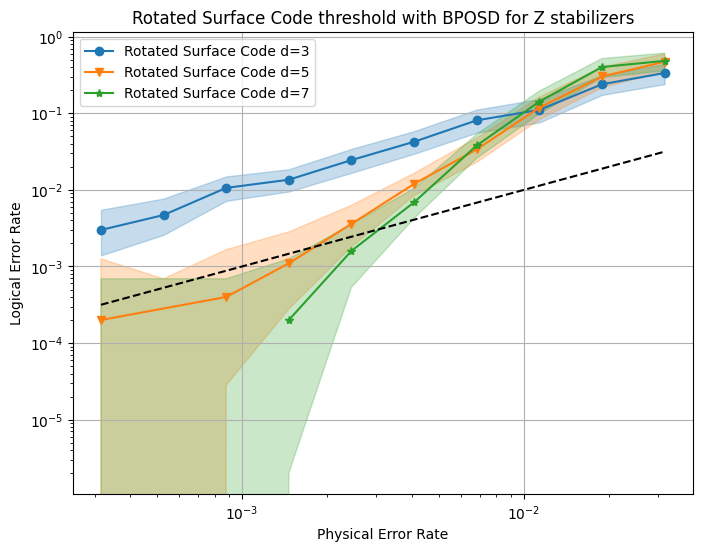

In [115]:
plot_results(samples)

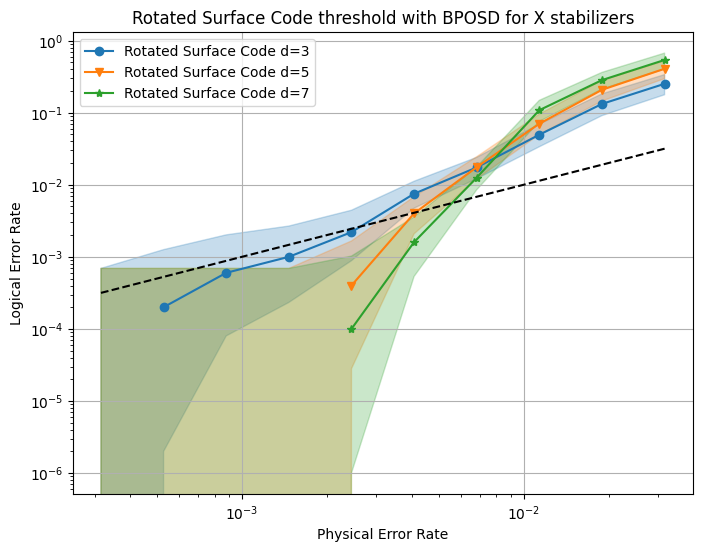

In [111]:
plot_results(samples)

In [91]:
# from sympy.abc import x, y, z
# dims = {x: 12, y: 6}
# poly_a = x**3 + y + y**2
# poly_b = y**3 + x + x**2

# code = qldpc.codes.BBCode(dims, poly_a, poly_b)
noise_range = np.logspace(-3.5, -1.5, 10)
code_name = "Rotated Surface Code"
sector = "Z"
file_name = f"{('_'.join(code_name.split())).lower()}_{sector}"
# base_code = qldpc.codes.HammingCode(2)
# group = qldpc.abstract.CyclicGroup(4)
# code = qldpc.codes.QTCode.random(group, base_code, seed=0)
# # code = qldpc.codes.SurfaceCode(3, rotated=True)


# code_a = qldpc.codes.ClassicalCode.random(5, 3, seed=0)
# code_b = qldpc.codes.ClassicalCode.random(5, 3, seed=1)

# code = qldpc.codes.HGPCode(code_a, code_b)

def generate_example_tasks():
    for noise in noise_range:
        for d in [3, 5, 7]:
            surface_code_circuit = stim.Circuit.generated(
                f"surface_code:rotated_memory_{sector.lower()}",
                rounds=2*d,
                distance=d,
                after_clifford_depolarization=noise,
                after_reset_flip_probability=noise,
                before_measure_flip_probability=noise,
                before_round_data_depolarization=noise
            )
            circuit = surface_code_circuit
            # code = qldpc.codes.SurfaceCode(d, rotated=True)
            # circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(code, sector=sector, repetitions=2*d).with_noise(NoiseModel(noise)))
            yield sinter.Task(
                circuit=circuit,
                detector_error_model=circuit.detector_error_model(decompose_errors=False),
                json_metadata={'noise': noise, 'd': d, 'repetitions': d },
            )


def run_simulation(overwrite=True):

    filename = f'bposd_{file_name}.csv'
    
    if overwrite:
        if pathlib.Path(filename).is_file():
            pathlib.Path(filename).unlink()

    samples = sinter.collect(
        num_workers=10,
        max_shots=10_000,
        max_errors=100,
        tasks=generate_example_tasks(),
        decoders=['bposd'],
        custom_decoders={'bposd': SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0")
        },

        print_progress=True,
        save_resume_filepath=filename,
    )
    return(samples)

In [92]:
samples = run_simulation()
samples

Starting 10 workers...
Running...
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=0.00031622776601683794,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=5,noise=0.00031622776601683794,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=0.00031622776601683794,repetitions=7}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=0.0005274997063702619,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=5,noise=0.0005274997063702619,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=0.0005274997063702619,repetitions=7}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=0.0008799225435691075,repetitions=3}
    bposd processe

[sinter.TaskStats(strong_id='b5d30e3b856c8b83ea655daac0c3b25c44d709020cbaf5eb6ba298e9b4bae585', decoder='bposd', json_metadata={'noise': 0.00031622776601683794, 'd': 3, 'repetitions': 3}, shots=10000, errors=4, seconds=1.2121941820041684),
 sinter.TaskStats(strong_id='6319927e7f204ea2638ffa19d952381f7a491dbf5885417cf21a0d947f0a4fab', decoder='bposd', json_metadata={'noise': 0.0005274997063702619, 'd': 3, 'repetitions': 3}, shots=10000, errors=11, seconds=1.2543730619981943),
 sinter.TaskStats(strong_id='6b90f1997cbef0a0c6ec27f4fe0d9684373993376e0ca3cc46c2c95dd7d821f0', decoder='bposd', json_metadata={'noise': 0.0008799225435691075, 'd': 3, 'repetitions': 3}, shots=10000, errors=40, seconds=1.490065849997336),
 sinter.TaskStats(strong_id='367b15b92e25e100901aeb9222aec981548b3304b8330fc828a27fb832aa0cd1', decoder='bposd', json_metadata={'noise': 0.00031622776601683794, 'd': 5, 'repetitions': 5}, shots=10000, seconds=12.210242819004634),
 sinter.TaskStats(strong_id='5ecf00af81f6a8cc7f2155

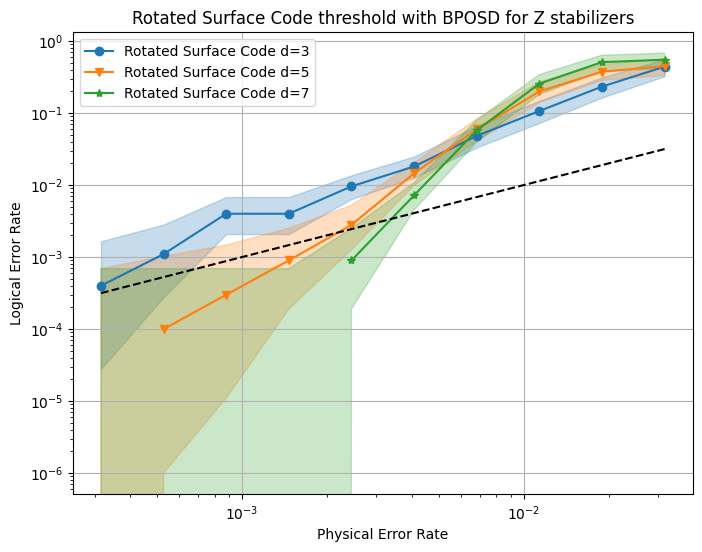

In [93]:
plot_results(samples)

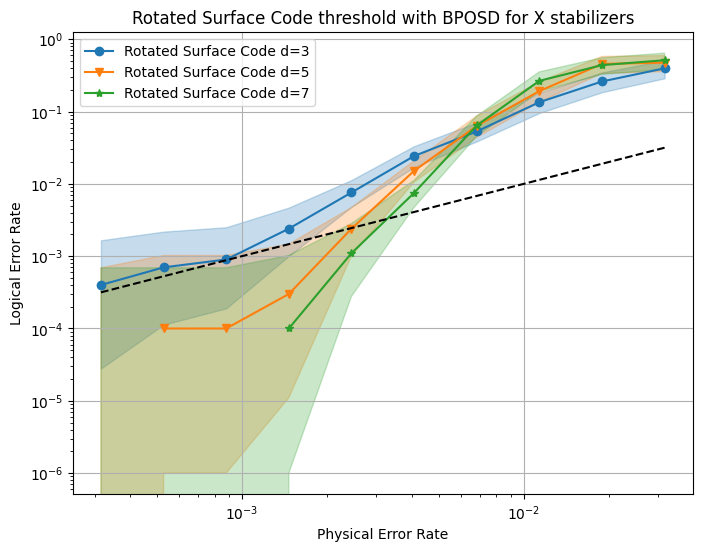

In [90]:
plot_results(samples)

# Archive

In [3]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int, decompose_errors=True, ignore_decomposition_failures=False) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model()
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

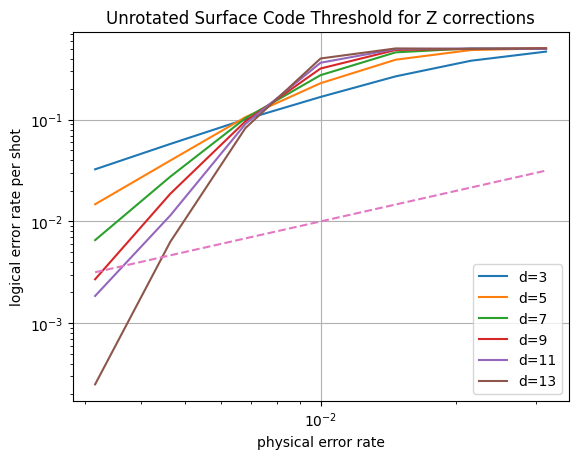

In [4]:
import matplotlib.pyplot as plt

num_shots = 20_000
noise_range = np.logspace(-3.5, -1.5, 10)
for d in [3, 5, 7, 9, 11, 13]:
    xs = []
    ys = []
    for noise in noise_range:
        surface_code_circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d*3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise
        )
        circuit = surface_code_circuit
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.plot(xs, xs, "--")
plt.loglog()
plt.grid()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("Unrotated Surface Code Threshold for Z corrections")
plt.legend()
plt.show()

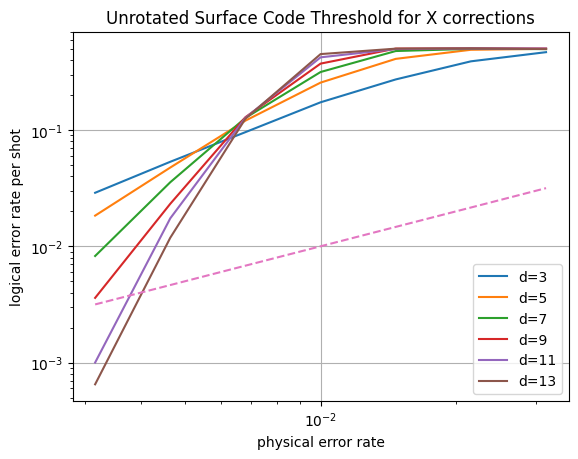

In [5]:
import matplotlib.pyplot as plt

num_shots = 20_000
noise_range = np.logspace(-2.5, -1.5, 7)
for d in [3, 5, 7, 9, 11, 13]:
    xs = []
    ys = []
    for noise in noise_range:
        surface_code_circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_x",
            rounds=d*3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise
        )
        circuit = surface_code_circuit
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.plot(xs, xs, "--")
plt.loglog()
plt.grid()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("Unrotated Surface Code Threshold for X corrections")
plt.legend()
plt.show()